In [196]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Read in and split data

In [230]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [231]:
# Clean training data set
train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train = train.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], axis=1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [232]:
# Clean test data set
test['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test = test.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875


## Make XGB model and Tune parameters

In [203]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    '''
    Parameters
    ----------
    alg: XGB sklearn model
        The initialized XGB sklearn model
    dtrain: pandas DataFrame
        The pandas training data set
    predictors: python List
        List of labels for predcitions
    target: python String
        Target column name
    useTrainCV: boolean
        If cv, then True, else, False
    cv_folds: int
        Number of folds for cv
    early_stopping_rounds: int
        Number of rounds before stopping early
        
    Returns
    -------
    Prints  the accuracy, AUC score, and feature importance plot.
    '''
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9001
AUC Score (Train): 0.958297


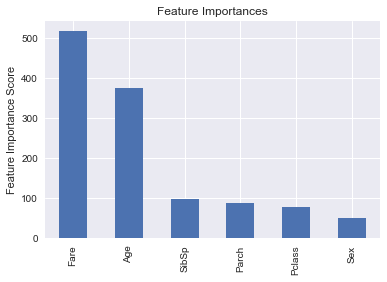

In [211]:
target = 'Survived'
predictors = [x for x in train.columns if x != target]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors, target)

In [218]:
param_test = {
 'learning_rate': [x/1000.0 for x in range(0, 200, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid=param_test, scoring='roc_auc', iid=False, cv=5)
gsearch.fit(train[predictors],train[target])
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.50000, std: 0.00000, params: {'learning_rate': 0.0},
  mean: 0.86661, std: 0.03473, params: {'learning_rate': 0.005},
  mean: 0.86719, std: 0.03522, params: {'learning_rate': 0.01},
  mean: 0.86892, std: 0.03512, params: {'learning_rate': 0.015},
  mean: 0.86930, std: 0.03601, params: {'learning_rate': 0.02},
  mean: 0.87105, std: 0.03601, params: {'learning_rate': 0.025},
  mean: 0.87098, std: 0.03676, params: {'learning_rate': 0.03},
  mean: 0.87102, std: 0.03679, params: {'learning_rate': 0.035},
  mean: 0.87239, std: 0.03852, params: {'learning_rate': 0.04},
  mean: 0.87278, std: 0.03729, params: {'learning_rate': 0.045},
  mean: 0.87400, std: 0.03645, params: {'learning_rate': 0.05},
  mean: 0.87354, std: 0.03604, params: {'learning_rate': 0.055},
  mean: 0.87403, std: 0.03476, params: {'learning_rate': 0.06},
  mean: 0.87423, std: 0.03430, params: {'learning_rate': 0.065},
  mean: 0.87520, std: 0.03309, params: {'learning_rate': 0.07},
  mean: 0.87501, std: 0.03289, par

In [219]:
param_test1 = {
 'max_depth': range(3,10,2),
 'min_child_weight': range(1,10,2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.12, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid=param_test1, scoring='roc_auc', iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.87397, std: 0.03106, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86892, std: 0.02946, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.87280, std: 0.02707, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87193, std: 0.02683, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.86950, std: 0.02560, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: 0.87674, std: 0.03216, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.87118, std: 0.02589, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.87503, std: 0.02960, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.87169, std: 0.02551, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.87322, std: 0.02446, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: 0.87166, std: 0.03068, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.87433, std: 0.02944, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.87252, std: 0.02681, params: {

In [220]:
param_test2 = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [0, 1, 2]
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.12, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid=param_test2, scoring='roc_auc', iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.87417, std: 0.03114, params: {'max_depth': 4, 'min_child_weight': 0},
  mean: 0.87424, std: 0.03261, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.87556, std: 0.02949, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.87312, std: 0.03307, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.87674, std: 0.03216, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.87604, std: 0.02940, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.87112, std: 0.03169, params: {'max_depth': 6, 'min_child_weight': 0},
  mean: 0.87409, std: 0.02849, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.87660, std: 0.02939, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 1},
 0.8767370471414443)

In [160]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0, 10)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.12, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid=param_test3, scoring='roc_auc', iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.87674, std: 0.03216, params: {'gamma': 0.0},
  mean: 0.87341, std: 0.03075, params: {'gamma': 0.1},
  mean: 0.87436, std: 0.03184, params: {'gamma': 0.2},
  mean: 0.87569, std: 0.02981, params: {'gamma': 0.3},
  mean: 0.87698, std: 0.03132, params: {'gamma': 0.4},
  mean: 0.87833, std: 0.03182, params: {'gamma': 0.5},
  mean: 0.87686, std: 0.03150, params: {'gamma': 0.6},
  mean: 0.87642, std: 0.03152, params: {'gamma': 0.7},
  mean: 0.87440, std: 0.02945, params: {'gamma': 0.8},
  mean: 0.87654, std: 0.03193, params: {'gamma': 0.9}],
 {'gamma': 0.5},
 0.878330462583554)


Model Report
Accuracy : 0.9012
AUC Score (Train): 0.960486


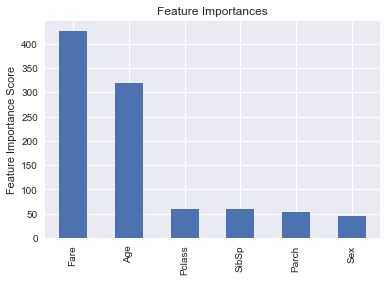

In [221]:
xgb2 = XGBClassifier(
 learning_rate=0.12,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors, target)

In [222]:
param_test4 = {
 'subsample':[i/10.0 for i in range(1,10)],
 'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.12, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid=param_test4, scoring='roc_auc', iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.85647, std: 0.02353, params: {'subsample': 0.1, 'colsample_bytree': 0.5},
  mean: 0.86891, std: 0.02610, params: {'subsample': 0.2, 'colsample_bytree': 0.5},
  mean: 0.86844, std: 0.02592, params: {'subsample': 0.3, 'colsample_bytree': 0.5},
  mean: 0.87263, std: 0.02797, params: {'subsample': 0.4, 'colsample_bytree': 0.5},
  mean: 0.87513, std: 0.02792, params: {'subsample': 0.5, 'colsample_bytree': 0.5},
  mean: 0.87218, std: 0.02599, params: {'subsample': 0.6, 'colsample_bytree': 0.5},
  mean: 0.87581, std: 0.02970, params: {'subsample': 0.7, 'colsample_bytree': 0.5},
  mean: 0.87663, std: 0.03270, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: 0.87362, std: 0.02844, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: 0.85647, std: 0.02353, params: {'subsample': 0.1, 'colsample_bytree': 0.6},
  mean: 0.86891, std: 0.02610, params: {'subsample': 0.2, 'colsample_bytree': 0.6},
  mean: 0.86844, std: 0.02592, params: {'subsample': 0.3, 'colsample_bytree'

In [224]:
param_test5 = {
 'subsample':[i/100.0 for i in range(70, 90, 5)],
 'colsample_bytree':[i/100.0 for i in range(60, 80, 5)]
}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.12, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid=param_test5, scoring='roc_auc', iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.87581, std: 0.02970, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.87404, std: 0.02873, params: {'subsample': 0.75, 'colsample_bytree': 0.6},
  mean: 0.87663, std: 0.03270, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.87489, std: 0.03076, params: {'subsample': 0.85, 'colsample_bytree': 0.6},
  mean: 0.87581, std: 0.02970, params: {'subsample': 0.7, 'colsample_bytree': 0.65},
  mean: 0.87404, std: 0.02873, params: {'subsample': 0.75, 'colsample_bytree': 0.65},
  mean: 0.87663, std: 0.03270, params: {'subsample': 0.8, 'colsample_bytree': 0.65},
  mean: 0.87489, std: 0.03076, params: {'subsample': 0.85, 'colsample_bytree': 0.65},
  mean: 0.87322, std: 0.03385, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.87147, std: 0.03269, params: {'subsample': 0.75, 'colsample_bytree': 0.7},
  mean: 0.87833, std: 0.03182, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.87321, std: 0.03089, params: {'subsample': 0.85, 'colsamp


Model Report
Accuracy : 0.9012
AUC Score (Train): 0.960486


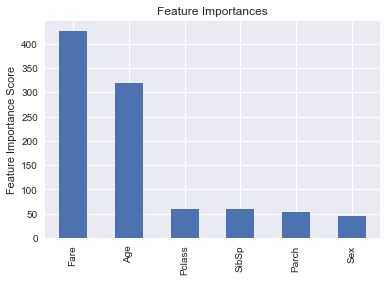

In [225]:
xgb3 = XGBClassifier(
 learning_rate=0.12,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.8,
 colsample_bytree=0.7,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors, target)

In [226]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.12, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0.5, subsample=0.8, colsample_bytree=0.7,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid=param_test6, scoring='roc_auc', iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.87833, std: 0.03182, params: {'reg_alpha': 1e-05},
  mean: 0.87366, std: 0.03224, params: {'reg_alpha': 0.01},
  mean: 0.87701, std: 0.03171, params: {'reg_alpha': 0.1},
  mean: 0.87455, std: 0.02881, params: {'reg_alpha': 1},
  mean: 0.78473, std: 0.03292, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.878330462583554)


Model Report
Accuracy : 0.9012
AUC Score (Train): 0.960486


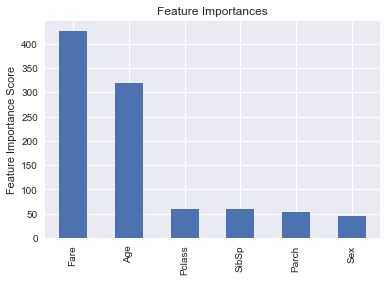

In [227]:
xgb4 = XGBClassifier(
 learning_rate=0.12,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.8,
 colsample_bytree=0.7,
 reg_alpha=1e-5,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors, target)

In [233]:
test['Survived'] = xgb4.predict(test[predictors])
test = test.set_index('PassengerId')
test = test['Survived']
test.head()

PassengerId
892    0
893    0
894    0
895    0
896    1
Name: Survived, dtype: int64

In [234]:
test.to_csv('data/submission_1.csv', header=True, index_label='PassengerId')